In [1]:
import numpy as np
import pickle
import os
import re

In [2]:
main_folder = "/projects/crunchie/boyanova/EEG_Things/eeg_experiment/"

In [3]:
def load_data(file):
   
    print('loading file: ' + file)
    with open(file, 'rb') as f:
        data = pickle.load(f)

    return(data)

def dump_data(data, filename):
    print('writing file: ' + filename)
    with open(filename, 'wb') as f:
        pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
        
def subsample_data(dat, sub_factor):
    dshape = dat['eeg'].shape
    sub_ix = list(range(0, dshape[-1], sub_factor))
    dat['eeg'] = dat['eeg'][:,:,sub_ix]
    dat['time'] = dat['time'][sub_ix]
    
    return dat
    
def get_pseudotrials(eeg_dat, tr_num):
    shape = eeg_dat.shape
    k = shape[1]
    l = int(shape[1] / k)
    
    while l < int(tr_num):
        k = k - 1
        l = int(shape[1] / k)

    eeg_dat = eeg_dat[:,np.random.permutation(shape[1]),:,:]
    eeg_dat = eeg_dat[:,:l*k,:,:]

    pst = np.reshape(eeg_dat, (shape[0], k, l, shape[2],shape[3]))
    pst = pst.mean(axis=1)

    return(pst, k)

def average_across_points(dat, window_size=10):
    dshape = dat['eeg'].shape
    
    # Reshape the data to have a new axis of length `window_size`
    new_length = dshape[-1] // window_size
    eeg_reshaped = dat['eeg'][:, :, :new_length * window_size].reshape(dshape[0], dshape[1], new_length, window_size)
    
    # Average across the new axis (the last one, `axis=-1`)
    dat['eeg'] = eeg_reshaped.mean(axis=-1)
    
    # Adjust the time array to match the new length
    dat['time'] = dat['time'][:new_length * window_size].reshape(new_length, window_size).mean(axis=-1)
    
    return dat

In [4]:
import matplotlib as mpl

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rc('image', cmap='viridis')

import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.family": "serif",  
    # use serif/main font for text elements
    })
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'font.weight': 'bold'})
plt.rcParams.update({'axes.linewidth': 2.5})
plt.rcParams.update({'axes.labelweight': 'bold'})
plt.rcParams.update({'axes.labelsize': 20})
plt.rc('legend',fontsize=12)

fix_det
loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_epoched/eeg_things_0013_fix.pickle
fix_rand
loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_epoched/eeg_things_0013_fix.pickle
img_det
loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_epoched/eeg_things_0013_img.pickle
img_rand
loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_epoched/eeg_things_0013_img.pickle


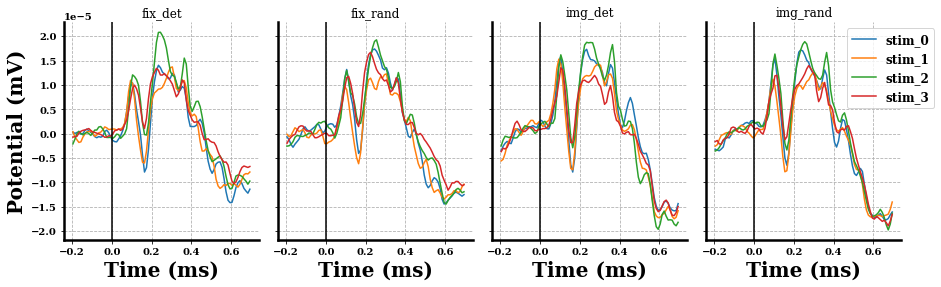

In [5]:
### Load Data
sub = 13
conditions_1 = ["fix", "img"]
conditions_2 = ["det", "rand"]
subsample_factor = 10

fig, axes = plt.subplots(1, 4, gridspec_kw={'wspace':0.1, 'hspace':0},
                             sharey = True, figsize=(15, 4))
ax_id = 0
for cond in conditions_1:
    for cond2 in conditions_2:
        
        cond_name = "{}_{}".format(cond, cond2)
        
        print(cond_name)
        dat_name = "/projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_epoched/eeg_things_{:04d}_{}.pickle".format(sub, cond)
        dat = load_data(dat_name)

        ### Subsample data
        #dat = subsample_data(dat, subsample_factor)
        dat = average_across_points(dat, window_size=10)

        ### Clean channels
        chan_mask = np.isin(dat["channels"], np.asarray([ch for ch in dat["channels"] if re.match(r'^(O|P)', ch)]))
        
        ### Button press mask
        bt_press = dat["button_press_mask"]
        dat["eeg"] = dat["eeg"][~bt_press]
        dat["ids"] = dat["ids"][~bt_press]

        ### Select condition 
        image_labels = [1,2,3,4]
        if cond2 == "rand":
            image_labels = [im + 10 for im in image_labels]

        mask = np.isin(dat["ids"], image_labels)

        eeg_ = dat["eeg"][mask, :][:, chan_mask, :]
        ids_ = dat["ids"][mask]

        ### Get vars
        n_conditions = len(image_labels)
        n_sensors = eeg_.shape[1]
        n_time = eeg_.shape[-1]
        
        ### Randomly pick 300 trials per conditoin 
        trial_lim = 150 
        eeg_svm = np.full((len((np.unique(ids_))), trial_lim, eeg_.shape[1], eeg_.shape[2]), np.nan)


        for idx, x in enumerate(np.unique(ids_)):
            total_num_trials = len(ids_[ids_ == x])

            # Define the range
            range_array = np.arange(0, total_num_trials)

            # Pick x random idx without repetition
            random_numbers = np.random.choice(range_array, trial_lim, replace=False)

            # Select
            eeg_svm[idx, :, :, :] = eeg_[ids_== x][random_numbers, :, :]
        
        eeg_trial_erp = np.mean(eeg_svm, axis = 1)
        eeg_channel_erp = np.mean(eeg_trial_erp, axis = 1)
        
        for x in range(4):
            axes[ax_id].plot(dat["time"], eeg_channel_erp[x], label = "stim_{}".format(x))
    

        #axes[ax_id].legend()
        axes[ax_id].set_title(cond_name)
        axes[ax_id].set_xlabel("Time (ms)")
        axes[ax_id].grid(linestyle = "--")
        axes[ax_id].axvline(0, color = "k")
        
        ax_id += 1

axes[0].set_ylabel("Potential (mV)")
axes[ax_id-1].legend(loc = "upper right",  bbox_to_anchor=(1.2, 1.0))
plt.savefig(os.path.join(main_folder, f"results/{sub:02d}_ERPs.png"))

In [11]:
### Load Data

conditions_1 = ["fix", "img"]
conditions_2 = ["det", "rand"]
subsample_factor = 10
subject_data = []
for sub in [2,3,4,5,7,8,10,11,12]:
    for cond in conditions_1:
        for cond2 in conditions_2:

            cond_name = "{}_{}".format(cond, cond2)

            print(cond_name)
            dat_name = "/projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_epoched/eeg_things_{:04d}_{}.pickle".format(sub, cond)
            dat = load_data(dat_name)

            ### Subsample data
            #dat = subsample_data(dat, subsample_factor)
            dat = average_across_points(dat, window_size=10)

            ### Clean channels
            chan_mask = np.isin(dat["channels"], np.asarray([ch for ch in dat["channels"] if re.match(r'^(O|P)', ch)]))

            ### Button press mask
            bt_press = dat["button_press_mask"]
            dat["eeg"] = dat["eeg"][~bt_press]
            dat["ids"] = dat["ids"][~bt_press]

            ### Select condition 
            image_labels = [1,2,3,4]
            if cond2 == "rand":
                image_labels = [im + 10 for im in image_labels]

            mask = np.isin(dat["ids"], image_labels)

            eeg_ = dat["eeg"][mask, :][:, chan_mask, :]
            ids_ = dat["ids"][mask]

            ### Get vars
            n_conditions = len(image_labels)
            n_sensors = eeg_.shape[1]
            n_time = eeg_.shape[-1]

            ### Randomly pick 300 trials per conditoin 
            trial_lim = 150 
            eeg_svm = np.full((len((np.unique(ids_))), trial_lim, eeg_.shape[1], eeg_.shape[2]), np.nan)


            for idx, x in enumerate(np.unique(ids_)):
                total_num_trials = len(ids_[ids_ == x])

                # Define the range
                range_array = np.arange(0, total_num_trials)

                # Pick x random idx without repetition
                random_numbers = np.random.choice(range_array, trial_lim, replace=False)

                # Select
                eeg_svm[idx, :, :, :] = eeg_[ids_== x][random_numbers, :, :]

            eeg_trial_erp = np.mean(eeg_svm, axis = 1)
            eeg_channel_erp = np.mean(eeg_trial_erp, axis = 1)
            subject_data.append(eeg_channel_erp)



fix_det
loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_epoched/eeg_things_0002_fix.pickle
fix_rand
loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_epoched/eeg_things_0002_fix.pickle
img_det
loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_epoched/eeg_things_0002_img.pickle
img_rand
loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_epoched/eeg_things_0002_img.pickle
fix_det
loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_epoched/eeg_things_0003_fix.pickle
fix_rand
loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_epoched/eeg_things_0003_fix.pickle
img_det
loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_epoched/eeg_things_0003_img.pickle
img_rand
loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_epoched/eeg_things_0003_img.pickle
fix_det
loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/

In [15]:
subject_data = np.array(subject_data)
grand_avg_erp = np.mean(subject_data, axis = 0)
#order: fix_det, fix_rand, img_det, img_rand


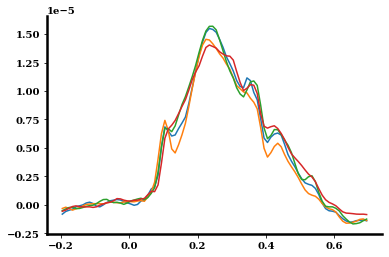

In [16]:
for x in range(4):
    plt.plot(dat["time"], grand_avg_erp[x], label = "stim_{}".format(x))

In [17]:
grand_avg_erp

array([[-8.20210586e-07, -5.86358190e-07, -4.73883780e-07,
        -3.82554767e-07, -1.70701325e-07, -9.24435956e-08,
        -9.03326862e-09,  1.60031732e-07,  2.30219549e-07,
         1.14017388e-07, -1.21246378e-07, -1.75757319e-07,
        -3.84677749e-09,  2.01105542e-07,  3.54507669e-07,
         4.10750534e-07,  4.63104869e-07,  4.23274075e-07,
         2.93402501e-07,  1.73870677e-07,  7.56645858e-08,
        -4.16892280e-08,  3.15843116e-08,  3.34701769e-07,
         4.42626440e-07,  8.39919046e-07,  1.38615762e-06,
         1.60830872e-06,  2.58446939e-06,  5.13190350e-06,
         6.85073187e-06,  6.47456253e-06,  6.04679101e-06,
         6.13704315e-06,  6.69673820e-06,  7.18470549e-06,
         7.70912059e-06,  8.91240035e-06,  1.03040091e-05,
         1.17537584e-05,  1.31649684e-05,  1.42850014e-05,
         1.51488286e-05,  1.54946446e-05,  1.54109551e-05,
         1.51618330e-05,  1.45379465e-05,  1.38414902e-05,
         1.30001308e-05,  1.23997541e-05,  1.17523978e-0